In [41]:
import torch
import torchvision
import torchvision.transforms as transforms

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage。我们将其标准化为范围在[-1, 1]之间的张量。

In [43]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 输入图像channel：1；输出channel：6；5x5卷积核
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 2x2 Max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 如果是方阵,则可以只使用一个数字进行定义
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


乐趣所致，现在让我们可视化部分训练数据。

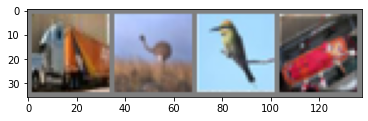

truck  bird  bird truck


In [44]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2.定义一个卷积神经网络
将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像(替代原来定义的单通道图像）。

In [45]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 3.定义损失函数和优化器
我们使用多分类的交叉熵损失函数和随机梯度下降优化器(使用momentum）。

In [46]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4.训练网络
事情开始变得有趣了。我们只需要遍历我们的数据迭代器，并将输入“喂”给网络和优化函数。

In [49]:
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        #inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.210
[1,  4000] loss: 1.876
[1,  6000] loss: 1.691
[1,  8000] loss: 1.588
[1, 10000] loss: 1.543
[1, 12000] loss: 1.477
[2,  2000] loss: 1.437
[2,  4000] loss: 1.401
[2,  6000] loss: 1.365
[2,  8000] loss: 1.338
[2, 10000] loss: 1.334
[2, 12000] loss: 1.305
Finished Training


让我们赶紧保存已训练得到的模型：

In [50]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

看[这里](https://pytorch.org/docs/stable/notes/serialization.html)熟悉更多PyTorch保存模型的细节

# 5.使用测试数据测试网络

我们已经在训练集上训练了2遍网络。但是我们需要检查网络是否学到了一些东西。

我们将通过预测神经网络输出的标签来检查这个问题，并和正确样本进行(ground-truth）对比。如果预测是正确的，我们将样本添加到正确预测的列表中。

ok，第一步。让我们展示测试集中的图像来熟悉一下。

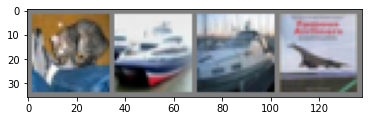

GroundTruth:    cat  ship  ship plane


In [51]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

下一步，让我们加载保存的模型（注意：在这里保存和加载模型不是必要的，我们只是为了解释如何去做这件事）

In [58]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引；

In [59]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    dog   dog  deer horse


In [60]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        outputs = outputs.to(device)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


这比随机选取(即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？

In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78 %
Accuracy of   car : 69 %
Accuracy of  bird : 25 %
Accuracy of   cat : 30 %
Accuracy of  deer : 60 %
Accuracy of   dog : 55 %
Accuracy of  frog : 48 %
Accuracy of horse : 62 %
Accuracy of  ship : 32 %
Accuracy of truck : 56 %


# 训练分类器
>原文:[https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)  
>译者：[bat67](https://github.com/bat67)  
>校验者：[FontTian](https://github.com/FontTian)， [yearing017](https://github.com/FontTian)
目前为止，我们已经看到了如何定义网络，计算损失，并更新网络的权重。所以你现在可能会想,

##  数据应该怎么办呢？

通常来说，当必须处理图像、文本、音频或视频数据时，可以使用python标准库将数据加载到numpy数组里。然后将这个数组转化成`torch.*Tensor`。

* 对于图片，有Pillow，OpenCV等包可以使用
* 对于音频，有scipy和librosa等包可以使用
* 对于文本，不管是原生python的或者是基于Cython的文本，可以使用NLTK和SpaCy

特别对于视觉方面，我们创建了一个包，名字叫`torchvision`，其中包含了针对Imagenet、CIFAR10、MNIST等常用数据集的数据加载器(data loaders），还有对图像数据转换的操作，即`torchvision.datasets`和`torch.utils.data.DataLoader`。

这提供了极大的便利，可以避免编写样板代码。

在这个教程中，我们将使用CIFAR10数据集，它有如下的分类：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”等。在CIFAR-10里面的图片数据大小是3x32x32，即：三通道彩色图像，图像大小是32x32像素。

![](img/cifar10.png)

cifar10

## 训练一个图片分类器

我们将按顺序做以下步骤：

1. 通过`torchvision`加载CIFAR10里面的训练和测试数据集，并对数据进行标准化  
2. 定义卷积神经网络  
3. 定义损失函数  
4. 利用训练数据训练网络  
5. 利用测试数据测试网络  

### 1.加载并标准化
### CIFAR10
使用`torchvision`加载CIFAR10超级简单。
```python
import torch
import torchvision
import torchvision.transforms as transforms
```
torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage。我们将其标准化为范围在[-1, 1]之间的张量。
```python
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
```
输出：
```python
Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz
Files already downloaded and verified
```
乐趣所致，现在让我们可视化部分训练数据。
```python
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
```
![](img/sphx_glr_cifar10_tutorial_001.png)
Out:
```python
horse horse horse   car
```
### 2.定义一个卷积神经网络
将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像(替代原来定义的单通道图像）。
```python
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
```
### 3.定义损失函数和优化器
我们使用多分类的交叉熵损失函数和随机梯度下降优化器(使用momentum）。
```python
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
```
### 4.训练网络
事情开始变得有趣了。我们只需要遍历我们的数据迭代器，并将输入“喂”给网络和优化函数。
```python
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        #inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
```
输出：
```python
[1,  2000] loss: 2.182
[1,  4000] loss: 1.819
[1,  6000] loss: 1.648
[1,  8000] loss: 1.569
[1, 10000] loss: 1.511
[1, 12000] loss: 1.473
[2,  2000] loss: 1.414
[2,  4000] loss: 1.365
[2,  6000] loss: 1.358
[2,  8000] loss: 1.322
[2, 10000] loss: 1.298
[2, 12000] loss: 1.282
Finished Training
```
让我们赶紧保存已训练得到的模型：
```python
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
```
看[这里](https://pytorch.org/docs/stable/notes/serialization.html)熟悉更多PyTorch保存模型的细节
### 5.使用测试数据测试网络
我们已经在训练集上训练了2遍网络。但是我们需要检查网络是否学到了一些东西。

我们将通过预测神经网络输出的标签来检查这个问题，并和正确样本进行(ground-truth）对比。如果预测是正确的，我们将样本添加到正确预测的列表中。

ok，第一步。让我们展示测试集中的图像来熟悉一下。
```python
dataiter = iter(testloader)
images, labels = dataiter.next()

# 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
```
![](img/sphx_glr_cifar10_tutorial_002.png)
```python
GroundTruth:    cat  ship  ship plane
```
下一步，让我们加载保存的模型（注意：在这里保存和加载模型不是必要的，我们只是为了解释如何去做这件事）
```python
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)
```
ok，现在让我们看看神经网络认为上面的例子是:
```python
outputs = net(images)
```
输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引；
```python
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
```
输出：
```python
Predicted:    dog  ship  ship plane
```
结果还不错。

让我们看看网络在整个数据集上表现的怎么样。
```python
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        outputs = outputs.to(device)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
```
输出：
```python
Accuracy of the network on the 10000 test images: 55 %
```
这比随机选取(即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？
```python
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
```
输出：
```python
Accuracy of plane : 70 %
Accuracy of   car : 70 %
Accuracy of  bird : 28 %
Accuracy of   cat : 25 %
Accuracy of  deer : 37 %
Accuracy of   dog : 60 %
Accuracy of  frog : 66 %
Accuracy of horse : 62 %
Accuracy of  ship : 69 %
Accuracy of truck : 61 %
```